In [1]:
import gamspy as gp
import gamspy.math as gpm
from gamspy import Sum, Card, Container, Options, Problem, Sense

import sys
import numpy as np
import pandas as pd
import math
import itertools

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import contextily as ctx

options = Options(equation_listing_limit=0)
m = Container(options=options,debugging_level='keep')

In [2]:
drone = pd.read_csv("/home/samjenkins2001/CS524/Project/Optimize/drone.csv")
loc = pd.read_csv("/home/samjenkins2001/CS524/Project/Optimize/location.csv")

drone_df = pd.DataFrame(drone)
loc_df = pd.DataFrame(loc)

In [3]:
locations = list(loc_df["Location"])
models = list(drone_df["Drone Models"])
loc_df.index = locations
drone_df.index = models
loc_df = loc_df.drop(columns = "Location")
drone_df = drone_df.drop(columns = "Drone Models")
display(loc_df)
display(drone_df)

,Latitude,Longitude,Payload,Demand
Camp Randall,43.070227,-89.412687,5.0000,5 Footballs
Sam's Apartment,43.075462,-89.393407,2.6250,History of Optimization book
3006 Sunrise Ct,43.108656,-89.473928,5.0000,Bird Food
Kohl Center,43.069709,-89.396907,4.6875,5 New Basketball Jerseys
Computer Sciences Building,43.071286,-89.406561,4.9360,8 NVIDIA Jetsons
Noland Hall,43.071678,-89.404489,1.5000,4 cups of Pepper Seeds
Lake Mendota,43.107811,-89.419515,4.0000,Fishing Rod
The Kollege Klub,43.075951,-89.397279,3.7500,Bottle of NA Vodka
Tenney Park,43.092186,-89.367120,2.2000,Drinking Fountain Filter
The Bakke,43.076852,-89.420159,3.4500,5 BUCKS Pre Workout


,Carrying Capacity,Fly in Rain,Speed,Radius,Charging Current
MK30,5,1,80.47,32.1,840
MK27,5,0,80.47,16.1,560


In [4]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    
    a = math.sin(delta_phi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
    return R * c

# Define depot and charging station
depot = {"DWI 4": (43.103263, -89.323598)}
sellery = {"Sellery": (43.075182, -89.400503)}

# Consumer locations with payload weights
locations = {
    "Camp Randall": (43.070227, -89.412687, 5.0),
    "Sam's Apartment": (43.075462, -89.393407, 2.6250),
    "3006 Sunrise Ct": (43.108656, -89.473928, 5.0000),
    "Kohl Center": (43.069709, -89.396907, 4.6875),
    "Computer Sciences Building": (43.071286, -89.406561, 4.936),
    "Noland Hall": (43.071678, -89.404489, 1.5000),
    "Lake Mendota": (43.107811, -89.419515, 4.0000),
    "The Kollege Klub": (43.075951, -89.397279, 3.75),
    "Tenney Park": (43.092186, -89.367120, 2.2000),
    "The Bakke": (43.076852, -89.420159, 3.4500),
    "The Nick": (43.070881, -89.399039, 4.16),
    "Governer's Mansion": (43.113096, -89.370588, 0.7000),
    "Wisconsin State Capital": (43.076583, -89.384819, 5.0000),
    "Henry Vilas Zoo": (43.060791, -89.410046, 3.0000),
    "The Edgewater": (43.079474, -89.389944, 3.4000),
    "Nandini's Apartment": (43.069867, -89.394065, 2.6250)
}

# Max initial ranges
initial_range_mk27 = 16.1
initial_range_mk30 = 32.1


In [5]:
def get_possible_routes():
    possible_routes = []
    unique_routes_set = set()  # Track unique routes by their items
    
    consumers = list(locations.keys())
    
    # Generate all subsets of consumers
    for r in range(1, len(consumers) + 1):
        for subset in itertools.combinations(consumers, r):
            total_payload = sum(locations[consumer][2] for consumer in subset)
            
            # Skip if total payload exceeds 5 lbs
            if total_payload > 5:
                continue
            
            # Create a sorted tuple of consumers for route uniqueness
            sorted_route = tuple(sorted(subset))
            if sorted_route in unique_routes_set:
                continue
            unique_routes_set.add(sorted_route)
            
            # Distance calculation: Depot -> Consumers -> Depot
            total_distance = 0
            start_lat, start_lon = depot["DWI 4"]
            
            for consumer in subset:
                consumer_lat, consumer_lon = locations[consumer][:2]
                total_distance += haversine(start_lat, start_lon, consumer_lat, consumer_lon)
                start_lat, start_lon = consumer_lat, consumer_lon
            
            # Return to depot
            total_distance += haversine(start_lat, start_lon, depot["DWI 4"][0], depot["DWI 4"][1])
            
            # Adjust range based on payload
            adjusted_range_mk30 = initial_range_mk30 * (1 - total_payload / 100)
            adjusted_range_mk27 = initial_range_mk27 * (1 - total_payload / 100)
            
            mk30_feasible = total_distance <= adjusted_range_mk30
            mk27_feasible = total_distance <= adjusted_range_mk27
            
            drone_type = None
            if mk30_feasible and mk27_feasible:
                drone_type = "Both"
            elif mk30_feasible:
                drone_type = "MK30"
            elif mk27_feasible:
                drone_type = "MK27"
            
            if drone_type:
                possible_routes.append({
                    "Route": subset,
                    "Payload (lbs)": total_payload,
                    "Total Distance (km)": total_distance,
                    "Drone Type": drone_type
                })
    
    return possible_routes


# Get all possible routes
routes = get_possible_routes()

# Convert to DataFrame and display
routes_df = pd.DataFrame(routes)
routes_df.to_csv('routes.csv', index=False)
display(routes_df)

,Route,Payload (lbs),Total Distance (km),Drone Type
0,"(Camp Randall,)",5.0000,16.227811,MK30
1,"(Sam's Apartment,)",2.6250,12.913810,Both
2,"(3006 Sunrise Ct,)",5.0000,24.437757,MK30
3,"(Kohl Center,)",4.6875,14.051669,Both
4,"(Computer Sciences Building,)",4.9360,15.235831,Both
5,"(Noland Hall,)",1.5000,14.897702,Both
6,"(Lake Mendota,)",4.0000,15.606467,MK30
7,"(The Kollege Klub,)",3.7500,13.419655,Both
8,"(Tenney Park,)",2.2000,7.484415,Both
9,"(The Bakke,)",3.4500,16.746026,MK30


In [15]:
# Mapping location names to integers
location_to_int = {
    "Camp Randall": 1,
    "Sam's Apartment": 2,
    "3006 Sunrise Ct": 3,
    "Kohl Center": 4,
    "Computer Sciences Building": 5,
    "Noland Hall": 6,
    "Lake Mendota": 7,
    "The Kollege Klub": 8,
    "Tenney Park": 9,
    "The Bakke": 10,
    "The Nick": 11,
    "Governer's Mansion": 12,
    "Wisconsin State Capital": 13,
    "Henry Vilas Zoo": 14,
    "The Edgewater": 15,
    "Nandini's Apartment": 16,
}

# Generate tuples of customers (as integers) and their corresponding routes
def generate_customer_route_tuples(routes_df):
    customer_route_tuples = []

    # Iterate over each row in the DataFrame
    for route_index, route in routes_df.iterrows():
        route_customers = route['Route']  # Get the list of customer names for this route
        
        for customer in route_customers:
            customer_int = location_to_int[customer]  # Map customer name to integer
            customer_route_tuples.append((str(customer_int), f'r{route_index + 1}'))  # 1-based route index

    return customer_route_tuples


# Generate the customer-route tuples
customer_route_tuples = generate_customer_route_tuples(routes_df)
# payload_list = loc_df["Payload"].tolist()


In [ ]:
## Variables to add
# Number of MK30 Drones used
# Number of MK27 Drones used
# Amount of charge used on MK30 Drones (Wh)
# Amount of charge used on MK27 Drones (Wh)
mk30 = m.addSet('mk30', description='Amount of mk30 Drones in stock', records = [i+1 for i in range(10)])
mk27 = m.addSet('mk27', description='Amount of mk27 Drones in stock', records = [i+1 for i in range(20)])
s = m.addSet('s',description='Consumers',records=[i+1 for i in range(16)])
j = m.addSet('j',description='routes',records=['r'+str(i+1) for i in range(37)])
C = m.addSet('C',[s,j],description="customer covered by route", records = customer_route_tuples)

max_battery = m.addParameter("max_battery", records=100)

x = m.addVariable('x','binary',domain=[j])
mk27_battery = m.addVariable('mk27_battery', 'positive', domain=[mk27])
mk30_battery = m.addVariable('mk30_battery', 'positive', domain=[mk30])

cover = m.addEquation('cover',domain=[s])
cover[s]= Sum(C[s,j], x[j]) >= 1

mk30_battery_drain = m.addEquation('mk30_battery_drain', domain=j)
mk30_battery_drain = mk30_battery == max_battery - distance * (max_battery / initial_range_mk30) * (1 + payload_drain * payload)

mk27_battery_drain = m.addEquation('mk27_battery_drain', domain=j)
mk27_battery_drain = mk27_battery == max_battery - distance * (max_battery / initial_range_mk27) * (1 + payload_drain * payload)

setcover = m.addModel('setcover',
    equations=m.getEquations(),
    problem=Problem.MIP,
    sense=Sense.MIN,
    objective=Sum(j, x[j]),
)

setcover.solve(output=None,options=Options(absolute_optimality_gap=0.999))
x.records.to_csv('optimal.csv', index=False)
display(x.records)

,j,level,marginal,lower,upper,scale
0,r1,1.0,1.0,0.0,1.0,1.0
1,r2,0.0,1.0,0.0,1.0,1.0
2,r3,1.0,1.0,0.0,1.0,1.0
3,r4,1.0,1.0,0.0,1.0,1.0
4,r5,1.0,1.0,0.0,1.0,1.0
5,r6,0.0,1.0,0.0,1.0,1.0
6,r7,0.0,1.0,0.0,1.0,1.0
7,r8,0.0,1.0,0.0,1.0,1.0
8,r9,0.0,1.0,0.0,1.0,1.0
9,r10,0.0,1.0,0.0,1.0,1.0


In [8]:
## Optimization Model

## Objective
# Minimize Energy Consumption

## Payload Constraint
# Each Drone <= 5 lbs

## Speed Constraint
# Each Drone <= 80.47 km / hr

## Weather Constraint
# If rain, only MK 30 Drones

## Range Constraint
# Ensure each drone returns to charging stations with non-zero battery life

## Demand Constraint
# Ensure each consumer gets their full product

## Charge Constraint
# Ensure each drone cannot be charged > 100%

## Item Constraint
# Ensure Drone only delivers whole items (ie. multiples of 0.5 lbs to the zoo for each animal slipper)

In [9]:
## Pareto Curve showing Tradeoff between Energy Consumption and Delivery Time

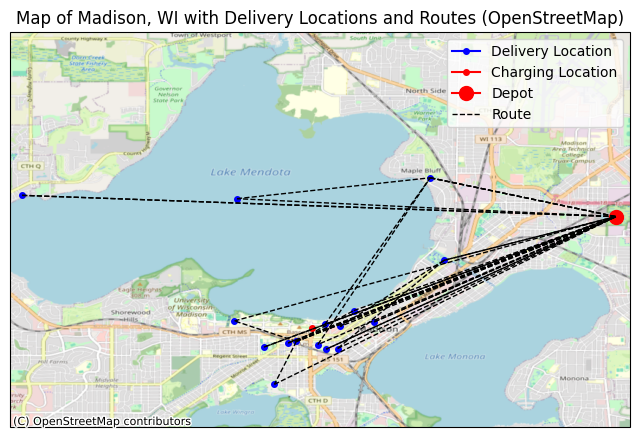

In [10]:
# Extract the selected routes (those with x[j] == 1)
selected_routes = [j for j in range(len(x.records)) if x.records.level[j] == 1.0]

# Coordinates for delivery locations (same as before)
# Coordinates for delivery locations (same as before)
latitudes = list(loc_df["Latitude"])
longitudes = list(loc_df["Longitude"])
coordinates = list(zip(latitudes, longitudes))

delivery_coords = coordinates[:-2]
charge_coords = coordinates[-2:]

# Set up the map
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-89.477, -89.32, 43.05, 43.15], crs=ccrs.PlateCarree())
ctx.add_basemap(ax, crs=ccrs.PlateCarree(), source=ctx.providers.OpenStreetMap.Mapnik)

# Plot delivery locations
for coord in delivery_coords:
    latitude = coord[0]
    longitude = coord[1]
    ax.plot(longitude, latitude, marker='o', color='blue', markersize=4, transform=ccrs.PlateCarree(), label="Delivery Location" if coord == delivery_coords[0] else "")

# Plot charge locations
for coord in charge_coords:
    latitude = coord[0]
    longitude = coord[1]
    ax.plot(longitude, latitude, marker='o', color='red', markersize=4 if coord == charge_coords[0] else 10, transform=ccrs.PlateCarree(), label="Charging Location" if coord == charge_coords[0] else "Depot")


depot_lat, depot_lon = charge_coords[1]  # Assuming the second charge location is the Depot

# Iterate over each selected route index
for route_index in selected_routes:
    # Get the list of customers for this route from your customer_route_tuples
    customers_in_route = [customer for customer, route in customer_route_tuples if route == f'r{route_index+1}']
    
    # Plot dashed lines from the Depot to each customer in the route
    previous_customer_coords = (depot_lat, depot_lon)  # Start with the Depot
    for customer_index in customers_in_route:
        # Get the customer's coordinates from delivery_coords (mapping customer to delivery point)
        customer_lat, customer_lon = delivery_coords[int(customer_index) - 1]  # Adjust for 0-indexing
        
        # Plot a dashed line from the previous customer (or Depot) to the current customer
        ax.plot([previous_customer_coords[1], customer_lon], 
                [previous_customer_coords[0], customer_lat], 
                color='black', linestyle='--', linewidth=1, transform=ccrs.PlateCarree(), label="Route" if (route_index == selected_routes[0] and previous_customer_coords == (depot_lat, depot_lon)) else "")
        
        # Update the previous customer coordinates
        previous_customer_coords = (customer_lat, customer_lon)

    # Return to the Depot after the last delivery
    ax.plot([previous_customer_coords[1], depot_lon], 
            [previous_customer_coords[0], depot_lat], 
            color='black', linestyle='--', linewidth=1, transform=ccrs.PlateCarree())

# Add the legend
plt.legend()

# Add a title
plt.title("Map of Madison, WI with Delivery Locations and Routes (OpenStreetMap)")

# Show the map
plt.show()
